In [148]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os, sys

In [149]:
%matplotlib inline

# Read single NetCDF file
using the Xarray package: https://xarray.pydata.org/en/stable/

In [150]:
ds=xr.open_dataset('ssp585/t2m/tasIs_LImon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc')

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tasIs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [151]:
ds.tasIs.comment

'quantity averaged over ice_sheet (meaning grounded ice sheet and floating ice shelf) only, to avoid contamination from other surfaces (eg: permafrost)'

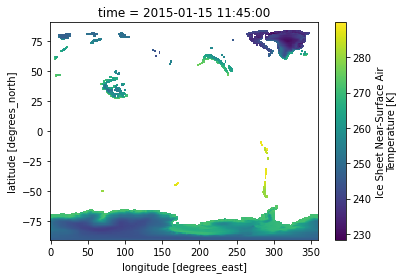

In [152]:
ds.tasIs[0].plot()

# Read multiple files at once
Use this when reading multiple time series of the same variable

https://xarray.pydata.org/en/stable/io.html?reading-multi-file-datasets

In [153]:
#ds=xr.open_mfdataset('ssp585/t2m/tas_Amon_*.nc',combine='by_coords')

# Antarctica mask

A simple AIS mask can be constructed off the land fraction mask that CESM provides. We just select everything south of 60S. 

In [157]:
ds2 = xr.open_dataset('cam_LANDFRAC.nc')

In [158]:
landfrac = ds2.LANDFRAC.squeeze()

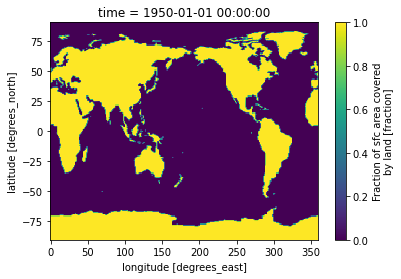

In [159]:
#landfrac[0:100,0:100].plot()
landfrac.plot()

In [160]:
lon = ds.lon
lat = ds.lat
lon2d, lat2d = np.meshgrid(lon,lat)

In [161]:
ais_mask = xr.where(lat2d<-60., landfrac, 0)
ais_mask.name = 'AIS_MASK'
ais_mask = ais_mask.reset_coords('time', drop=True) # drop time dimension

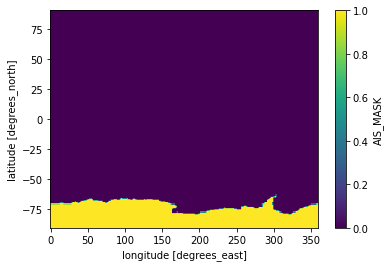

In [162]:
ais_mask.plot()

# Time series of mean annual temperature over AIS
To calculate a area-weighted mean temperature, we need to know what is the area of AIS. For this we read the `areacella` variable. 

In [163]:
ds_area = xr.open_dataset('fx/areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc')
area = ds_area.areacella

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [164]:
total_area_AIS = (ais_mask * area).sum().item()
print(total_area_AIS, area.units)

14162570772480.0 m2


In [165]:
total_area_AIS/1e6

14162570.77248

### Step 1: convert monthly to annual data

In [111]:
# days per month, assuming no leap years
dpm = np.array((31 ,28 ,31 ,30 ,31 ,30 ,31 ,31 ,30 ,31 ,30 ,31 )) 


def mul_with_dpm(data):
    """
    This helper function multiplies a monthly array (e.g. Xarray DataArray) with the number
    of days per month, and then divides by the total of days in the year. 
    """
    return (data * dpm[:,np.newaxis,np.newaxis]).sum(dim='time') / dpm.sum()

def monthly_to_yearly(data):
    """
    This function converts a 'timeseries' of monthly data to a timeseries of yearly data. 
    An approximation to this function is: 
    
        data.groupby('time.year').mean()
        
    But that doesn't take into account the different lengths of the months. 

    NOTE:
        This function assumes a 365-day calendar for each year (no leap, as is common in climate models).
    """
    out = data.groupby('time.year').apply(mul_with_dpm)
    out.attrs = data.attrs
    return out

Convert monthly data into annual data using either:
* Method 1: simple grouping per year
* Method 2: weighing the number of days per month

These methods will give a comparable, but slightly different answer. Let's go with method 2 since it's more accurate. 

In [114]:
#t2m_ann = ds.tas.groupby('time.year').mean() # Method 1
t2m_ann = monthly_to_yearly(ds.tasIs) # Method 2

In [115]:
t2m_ann.shape

(86, 192, 288)

### Step 1b: save annual files for later use

In [123]:
from pathlib import Path

In [133]:
dir_proc = 'data_processed'
if (not os.path.exists(dir_proc)):
    os.mkdir(dir_proc)

In [ ]:
scenario = 'ssp585'
varlist = 'tas', 'tasIs'

In [140]:
def process_scenario(scenario, root_dir='.'):
    vardirs = []
    for path in Path(os.path.join(root_dir, scenario)).iterdir():
        if path.is_dir():
            print(path)

In [141]:
main_loop('ssp585')

ssp585/fx
ssp585/t2m


In [135]:
list(p.iterdir())

[PosixPath('data_processed'),
 PosixPath('ssp585'),
 PosixPath('example notebook Nikola.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('.git'),
 PosixPath('tmp.nc'),
 PosixPath('cam_LANDFRAC.nc'),
 PosixPath('AIS_Grounded_basins_Zwally_CESMgrid.nc')]

In [125]:
variables = p.glob('*')

[PosixPath('ssp585'),
 PosixPath('example notebook Nikola.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('.git'),
 PosixPath('tmp.nc'),
 PosixPath('cam_LANDFRAC.nc'),
 PosixPath('AIS_Grounded_basins_Zwally_CESMgrid.nc')]

### Step 2: calculate AIS average

In [116]:
t2m_ann_ais = (t2m_ann * ais_mask.values * area).sum(dim=['lat','lon'])/total_area_AIS

In [117]:
t2m_ann_ais.load();

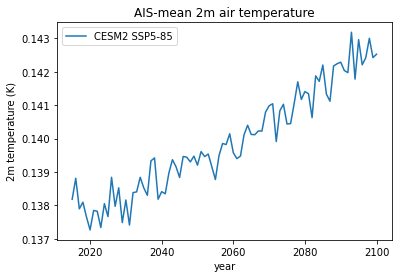

In [118]:
t2m_ann_ais.plot(label='CESM2 SSP5-85')
plt.title('AIS-mean 2m air temperature')
plt.ylabel('2m temperature (K)');
plt.legend()

In [119]:
t2m_ann_ais.to_netcdf('tmp.nc')

# Elevation

In [246]:
with xr.open_dataset('ssp585/fx/orog_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc') as ds:
    orog = ds.orog

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'orog' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [247]:
#orog.plot()

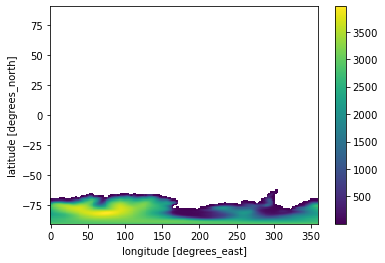

In [248]:
(orog*ais_mask).plot()

In [249]:
ais_oro = orog*ais_mask

A possible subselection of AIS grid points based on elevation (elev < 100 m)

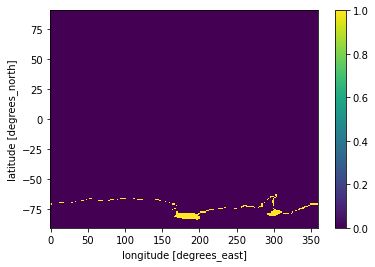

In [250]:
elev_sel = xr.where((ais_oro > 0.1) * (ais_oro < 100), 1, 0)
elev_sel.plot()

# Map projections

In [220]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [228]:
def add_2d_coordinate_information(var):
    lon2d, lat2d = np.meshgrid(var.lon,var.lat)
    var.coords['lon2d'] = xr.DataArray(lon2d, dims=('lat', 'lon'))
    var.coords['lat2d'] = xr.DataArray(lat2d, dims=('lat', 'lon'))   
    
    
def change_value_to_missing(var, value=0.0):
    return xr.where(var==value, np.NaN, var)

In [230]:
add_2d_coordinate_information(ais_mask)

# Set zero values to Not-A-Number, which removes them from the plot altogether. 
ais_mask = change_value_to_missing(ais_mask, value=0.0)

In [238]:
def layout_ax(ax):    
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN) ## BUG in cartopy 0.16: draws ocean everywhere on NorthPolarStereo projection
    ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)

Plot the AIS mask with a South Polar projection

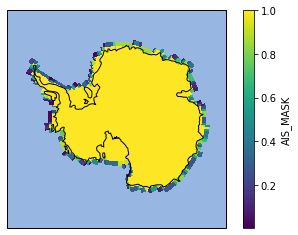

In [239]:
fig = plt.figure()
ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})

ax.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

layout_ax(ax)
ais_mask.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree())

In [233]:
with xr.open_dataset('AIS_Grounded_basins_Zwally_CESMgrid.nc') as ds:
    basins = ds.Zwallybasins

In [234]:
add_2d_coordinate_information(basins)
basins = change_value_to_missing(basins, value=0.0)

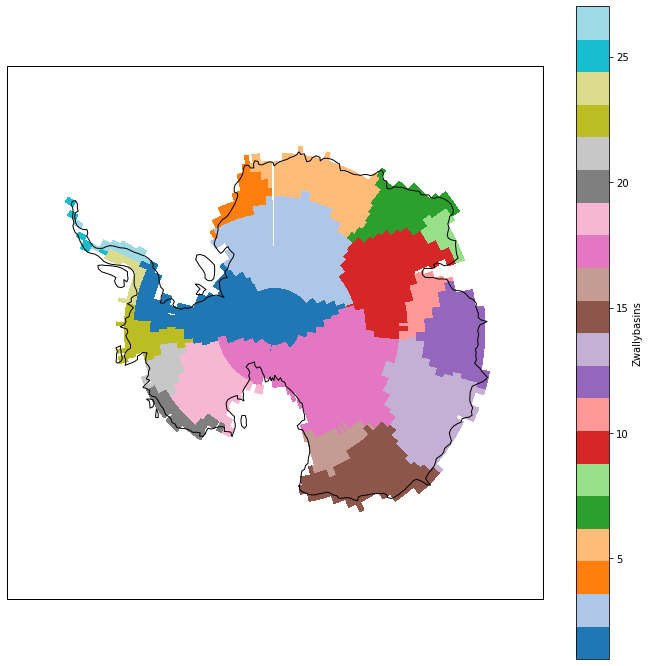

In [242]:
fig = plt.figure(figsize=(12,12))
ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})

ax.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

ax.coastlines()
basins.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree(), cmap='tab20')


In [256]:
def make_SouthPolar_plot_of_var(var, extent=(-180,180,-90,-60), figsize=(8,8)):
    """
    Convenience function to make a Polar Projection plot with few lines of code
    """
    add_2d_coordinate_information(var)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    ax.coastlines()  
    
    var.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree())

    return fig,ax

Now plot the selection we made earlier, based on the elevation < 100 m threshold.

(<Figure size 576x576 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ff9484631d0>)

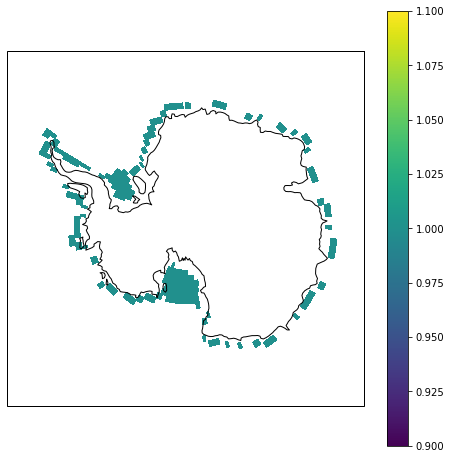

In [259]:
elev_sel = change_value_to_missing(elev_sel, value=0.0)
make_SouthPolar_plot_of_var(elev_sel)